# Quick guide to thermal noise

All circuits have some amount of thermal noise related to the bandwidth of the circuit. This noise can be described in terms of the  mean squared voltage that these thermal fluctuations. 

$$< V^2 > = 4 k_B T \int_0^\infty \eta(f) \Re \left[ Z(f)\right] df $$
where
$$\eta(f) = \frac{hf}{k_B T \left( e^\frac{hf}{k_B T} -1 \right)}$$


In most scenarios we treat $\eta(f)=1$ and then if we integrate over a particular bandwith $\Delta f$ we get 
$$<V^2> = 4 k_B T R \Delta f$$

Or in terms of power:
$$ P = \frac{<V^2 >}{R} = 4 k_B T \Delta f$$


In [1]:
from PyFFTTools import PyFFTTools as pft
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.constants
import matplotlib.style
import matplotlib as mpl
import math



#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_44605/2337369889.py:5: RuntimeWarning: invalid value encountered in divide
  return hf / (kt *(np.exp(hf/kt)-1))


Text(0, 0.5, '$\\eta(f)$')

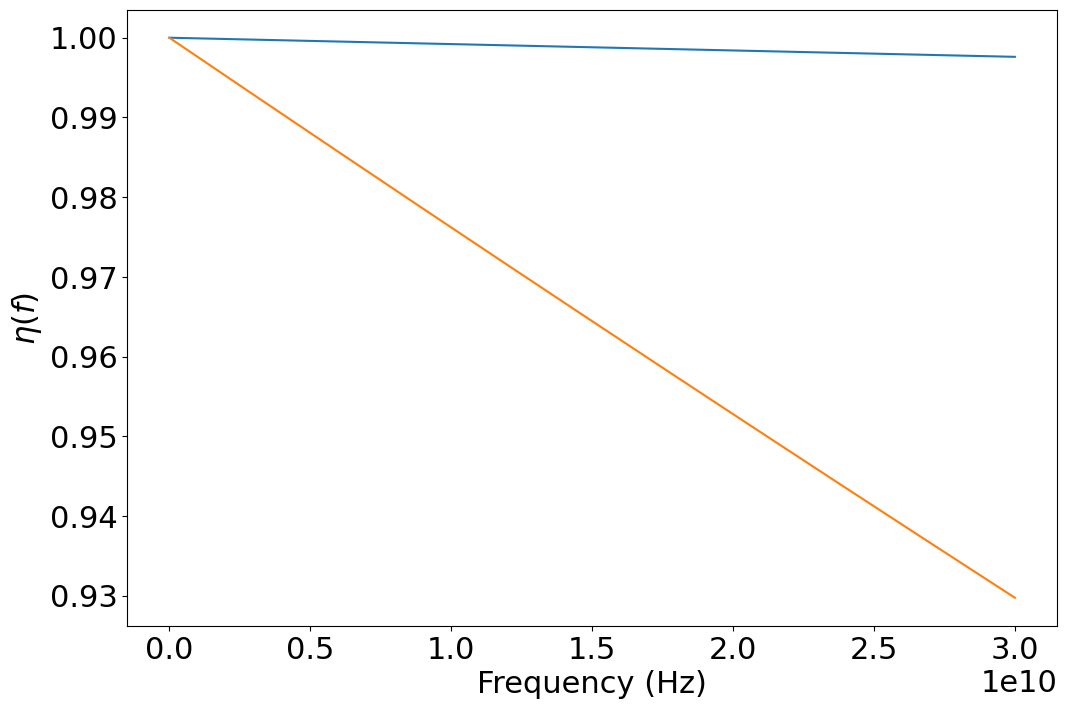

In [2]:
def etaOfF(f,T):
    hf=scipy.constants.h * f
    kt=scipy.constants.k * T
    
    return hf / (kt *(np.exp(hf/kt)-1))

f=np.linspace(0,30e9,10001)
  
fig,ax = plt.subplots()
ax.plot(f,etaOfF(f,300))
ax.plot(f,etaOfF(f,10))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("$\eta(f)$")

Estimated Gain 80.77935671744268
Power in 40MHZ  6.450392128e-05 W
Power in 40MHZ  -11.904138832174233 dBm


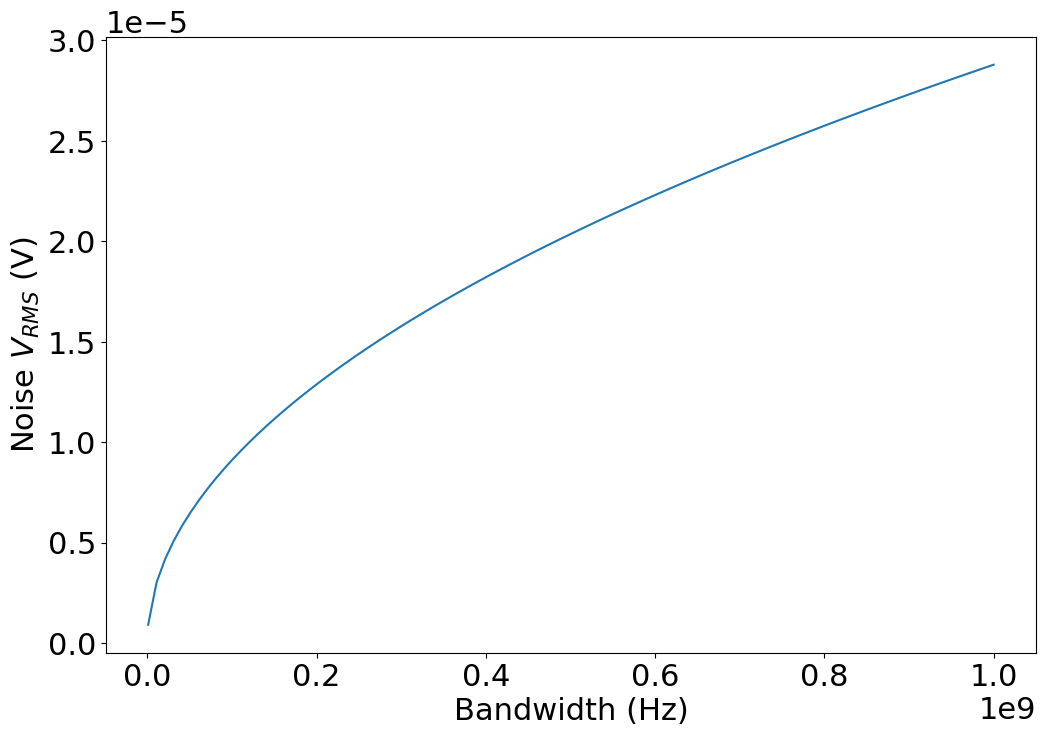

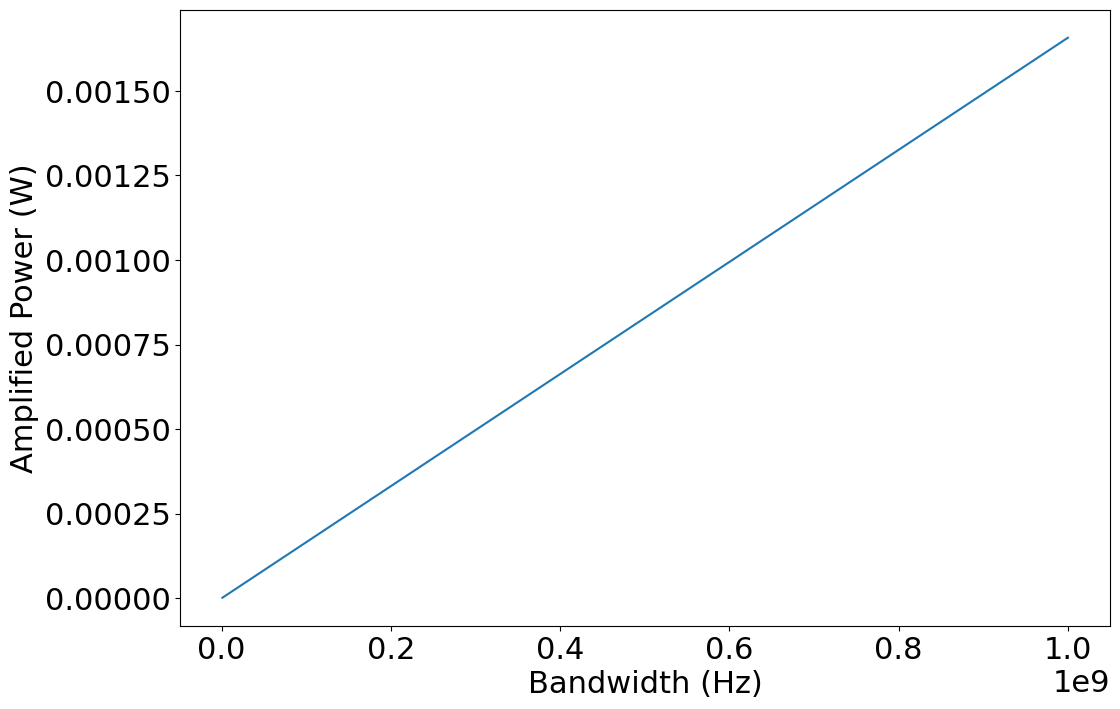

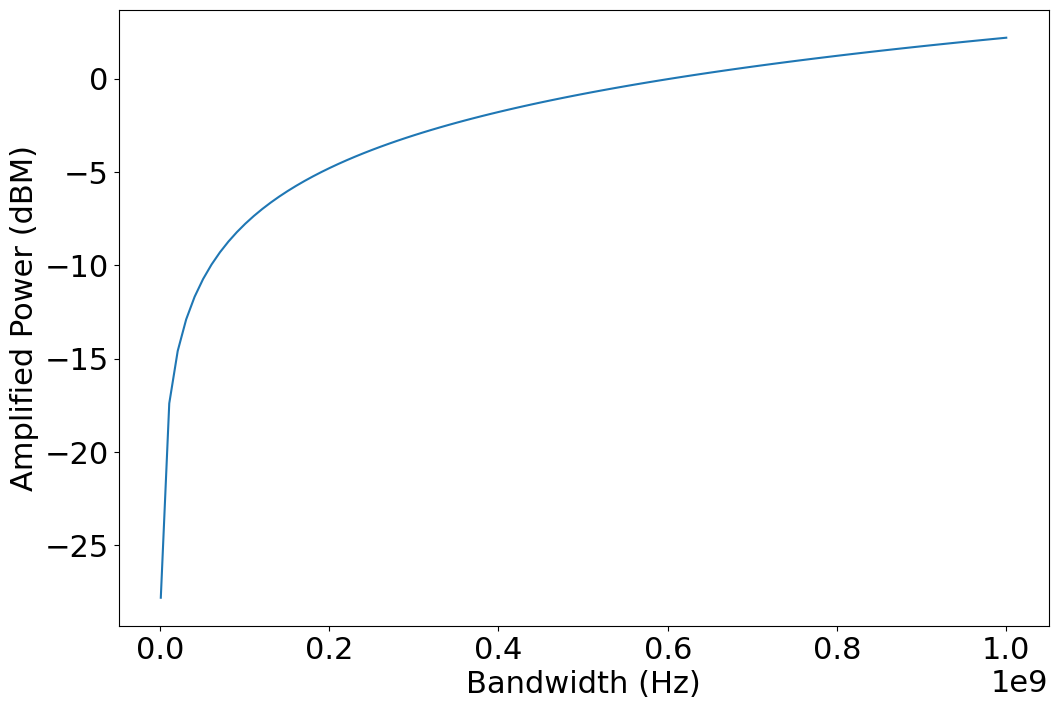

In [3]:
def getNoiseRMS(T,R,df):
    return np.sqrt(4 * scipy.constants.k * T *R *df)

def getGainFromNoiseRMS(vrms,T,R,df):
    noiseRMS=getNoiseRMS(T,R,df)
    return 20*np.log10(vrms/noiseRMS)

def convertPowerTodBm(P):
    mW=1e-3#mW
    return 10*np.log10(P/mW)

df=np.linspace(1e6,1000e6,101)
  
fig,ax = plt.subplots()
ax.plot(df,getNoiseRMS(300,50,df))
ax.set_xlabel("Bandwidth (Hz)")
ax.set_ylabel("Noise $V_{RMS}$ (V)")


gain=80
ampVrms=np.power(10,gain/20)*getNoiseRMS(300,50,df)
fig,ax = plt.subplots()
ax.plot(df,ampVrms*ampVrms/50)
ax.set_xlabel("Bandwidth (Hz)")
ax.set_ylabel("Amplified Power (W)")

ampVrms=np.power(10,gain/20)*getNoiseRMS(300,50,df)
fig,ax = plt.subplots()
ax.plot(df,convertPowerTodBm(ampVrms*ampVrms/50))
ax.set_xlabel("Bandwidth (Hz)")
ax.set_ylabel("Amplified Power (dBM)")

print("Estimated Gain",getGainFromNoiseRMS(0.171,273+22,50,300e6))
testVrms=np.power(10,gain/20)*getNoiseRMS(292,50,40e6)
print("Power in 40MHZ ",testVrms*testVrms/50,"W")
print("Power in 40MHZ ",convertPowerTodBm(testVrms*testVrms/50),"dBm")


## Quick aside on Discrete Fourier Transforms

The accepted inclusive defintion of the Discrete Fourier transform of a sequence of $N$ complex numbers ${x_n} := x_0, x_1, \ldots, x_{N-1}$ which results in $N$ complex numbers ${X_k} := X_0, X_1, \ldots, X_{N-1}$ is:
$$ X_k  = \sum_{n=0}^{N-1} x_n e^{ \frac{- i 2 \pi k n}{N}} $$

The corresponding inverse transform is:
$$ x_n  = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{ \frac{+ i 2 \pi k n}{N}} $$

With this definition we have Parseval's theorem which relates the sum of the magntidues in the thing we will eventually call the time domain ($x_n$) and the one we will call frequency domain ($X_k$):
$$ \sum_{n=0}^{N-1} \left| x_n \right|^2 = \frac{1}{N} \sum_{k=0}^{N-1} \left| X_k \right|^2 $$


### Special case: Real input
Most of the time we are interested in the special case where the (time domain) input of the Fourier transform is real (e.g. the voltages in a voltage-time waveform from an oscilloscope). In this special case we find that the two halfs of the transform have a conjugation symmetry:
$$ X_{k}^* = X_{N-k+1} $$

For this case we only need to look at the first $N/2$ elements of the (frequency domain) transform to get all of the information since the other half of the transform is just the complex the conjugate. Here we need to be a little careful to assure that when we are reading numbers in the frequency domain they make physical sense.

The normalisation we use here is that we set the magnitude of the $k$th frequency bin $F_k$ as
$$F_k = \frac{\sqrt{2}}{N} \left| X_k \right|$$
where $k \in 0,1, \ldots,N/2$



#### Why this normalisation?
With this normalisation we can test our scaling by assuming that our samples are voltages. Then if we have a 1V RMS sine wave signal across a 1 Ohm resistor the power in the given frequency bin is 1W where
$$ P_k = \frac{F_k^2}{R} $$

So if we want $P_k$ in terms of the $X_k$ we have
$$ P_k = \frac{2}{R N^2} \left| X_k \right|^2 $$

Now if we compare this to Parseval's theorem above we can see the factor of 2 comes from only using the first $N/2$ frequency bins, whilst the extra factor of $N$ in the denominator is from the definiition of the root mean square of the voltages, $x_n$.
$$ P = \frac{V_{RMS}^2}{R} = \sum_{n=0}^{N-1} \frac{1}{N} \frac{x_n^2}{R} = \sum_{k=0}^{(N/2) -1}  \frac{2}{R N^2} \left| X_k \right|^2 $$

RMS of y 5.976516543940962
Avg Power of y 35.71875000000002
Peak Power in 1 Frequency Bin 0.6328994971262634
Total Power 0.7143750000000005


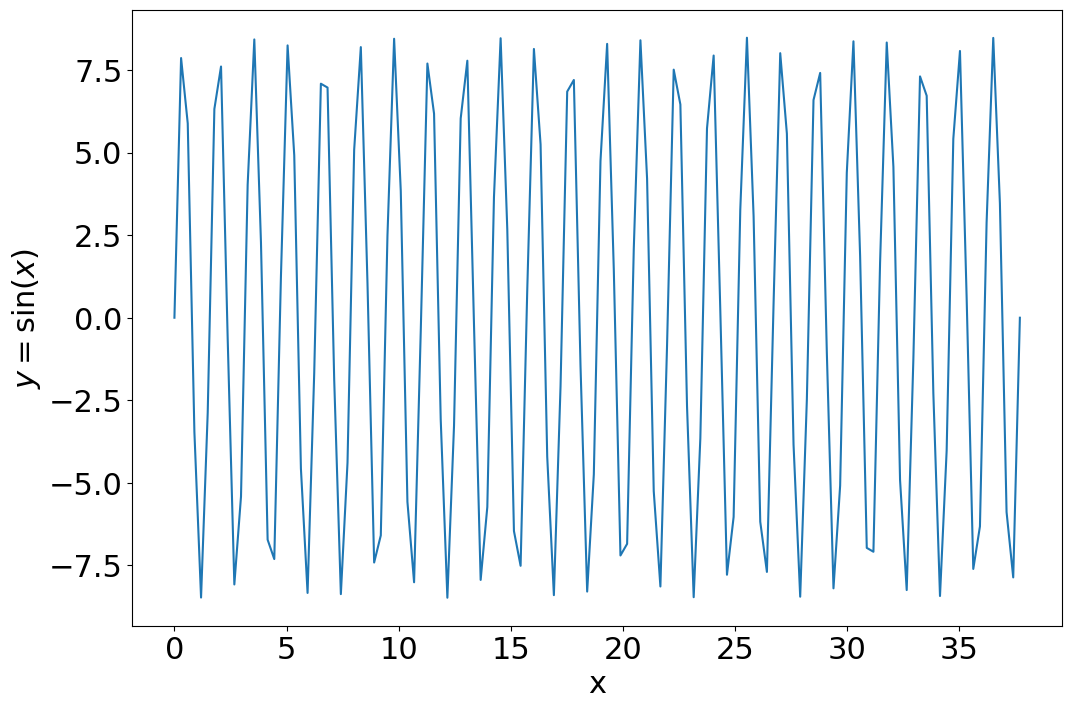

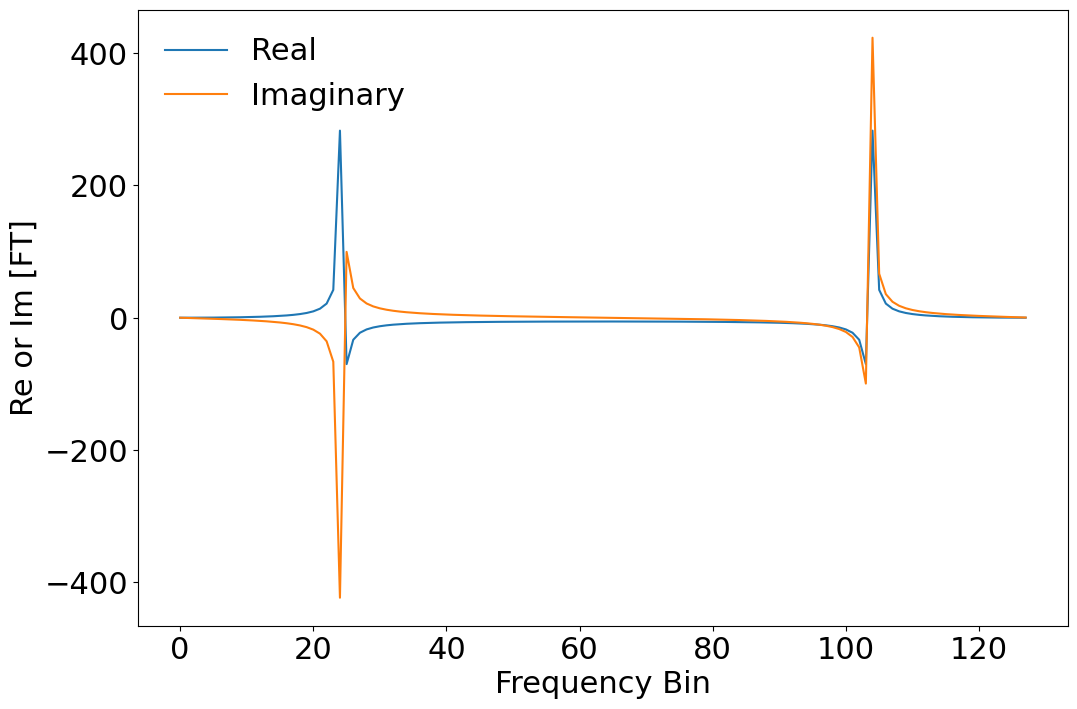

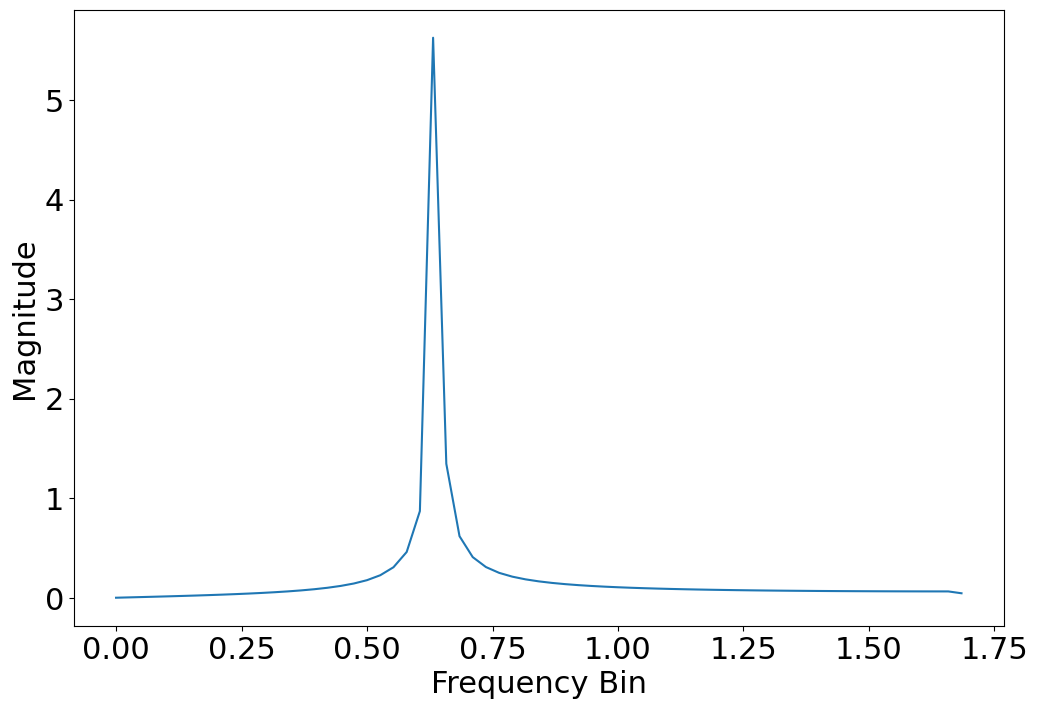

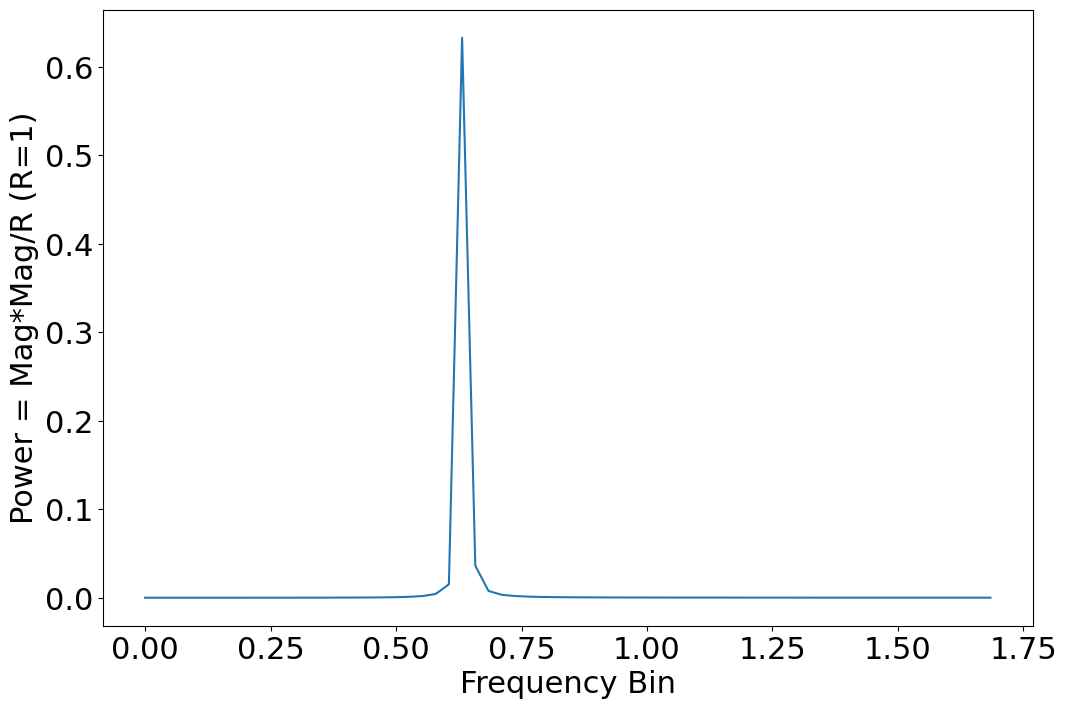

In [4]:


from scipy.fft import fft, ifft  # Import the fft and inverse fft functions
x=np.linspace(0,12*math.pi,128)
#y=4*np.sqrt(2)*np.sin(4*x) + 3*np.sqrt(2)*np.sin(3.1*x)
y=6*np.sqrt(2)*np.sin(4*x)  
fig,ax = plt.subplots()
ax.plot(x,y)
ax.set_xlabel("x")
ax.set_ylabel("$y=\sin(x)$")


ft=fft(y)
fig,ax = plt.subplots()
ax.plot(np.arange(len(y)),np.real(ft),label='Real')
ax.set_xlabel("Frequency Bin")
ax.set_ylabel("Re or Im [FT]")
ax.plot(np.arange(len(y)),np.imag(ft),label='Imaginary')
ax.legend()

xf=pft.getFrequencyBins(len(y),x[1]-x[0])

fig,ax=plt.subplots()
ax.plot(xf,pft.convertFFTToMag(ft))
ax.set_xlabel("Frequency Bin")
ax.set_ylabel("Magnitude")


fig,ax=plt.subplots()
ax.plot(xf,pft.convertFFTToPower(ft))
ax.set_xlabel("Frequency Bin")
ax.set_ylabel("Power = Mag*Mag/R (R=1)")

rmsy=pft.getRMS(y)
print("RMS of y",rmsy)
print("Avg Power of y",rmsy**2/1)  #V^2 /R
print("Peak Power in 1 Frequency Bin",np.max(pft.convertFFTToPower(ft)))
print("Total Power",np.sum(pft.convertFFTToPower(ft)))


## Aside: Understanding rfft vs fft

In [5]:

x=np.arange(21)
y=np.sin(20*x)
N=np.shape(x)[0]

from scipy.fft import fft, ifft  # Import the fft and inverse fft functions
from scipy.fft import rfft, irfft  # Import the fft and inverse fft functions

fftVals=fft(y)
rfftVals=rfft(y)
fftVals2=pft.convertRFFTtoFFT(rfftVals)
rfftVals2=pft.convertFFTtoRFFT(fftVals)

print(np.shape(fftVals))
print(np.shape(rfftVals))

print(fftVals)
print(fftVals2)
print(fftVals/fftVals2)
print(rfftVals)
print(rfftVals2)
print(rfftVals/rfftVals2)
print(N)
print(N//2)
print(np.shape(fftVals))
print(np.shape(rfftVals))
print(np.isreal(rfftVals))
print(np.iscomplex(rfftVals))


(21,)
(11,)
[ 0.75081152-0.j          0.77819096+0.22256726j  0.89101738+0.55691995j
  1.34056132+1.50047402j -4.25930388-9.00372774j -0.18571003-1.23668055j
  0.09669874-0.63913574j  0.19347369-0.3942595j   0.23839007-0.24641051j
  0.26084002-0.137023j    0.27043599-0.04410794j  0.27043599+0.04410794j
  0.26084002+0.137023j    0.23839007+0.24641051j  0.19347369+0.3942595j
  0.09669874+0.63913574j -0.18571003+1.23668055j -4.25930388+9.00372774j
  1.34056132-1.50047402j  0.89101738-0.55691995j  0.77819096-0.22256726j]
[ 0.75081152+0.j          0.77819096+0.22256726j  0.89101738+0.55691995j
  1.34056132+1.50047402j -4.25930388-9.00372774j -0.18571003-1.23668055j
  0.09669874-0.63913574j  0.19347369-0.3942595j   0.23839007-0.24641051j
  0.26084002-0.137023j    0.27043599-0.04410794j  0.27043599+0.04410794j
  0.26084002+0.137023j    0.23839007+0.24641051j  0.19347369+0.3942595j
  0.09669874+0.63913574j -0.18571003+1.23668055j -4.25930388+9.00372774j
  1.34056132-1.50047402j  0.89101738-0.5